<a href="https://colab.research.google.com/github/bolaris-sage/shark-research/blob/main/shark-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This analysis delves into the behavior of a female great white shark around Guadalupe Island, a critical habitat for these majestic creatures and a key area for marine conservation. From October 15th to 23rd, 2017, we collected data using various sensors, offering a window into the shark's world. Our goal is to uncover patterns in depth, environmental conditions, and movement, and to understand how these factors interplay. This study not only provides insights into the daily life of a great white shark but also contributes to broader marine conservation efforts. Key questions include the impact of environmental conditions on the shark's depth and activity levels. Interactive visualizations will guide us through this exploration.


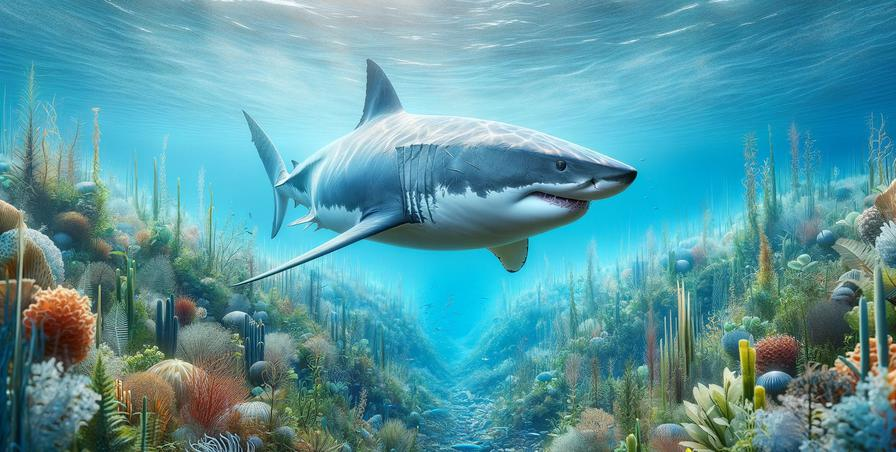

## Data Overview

### CEFAS 1 Female 4.5
- **Deployment Duration**: October 15, 2017 - October 23, 2017
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Sensors Count**: 5
- **Sensors**:
  - *Pressure*: Measures depth, crucial for understanding diving behavior.
  - *Temperature*: Helps correlate the shark's behavior with environmental conditions.
  - *3-axis accelerometer*: Tracks movement, vital for assessing energy expenditure and detailed movement patterns.
- **Accelerometer Attachment**: [Details if known, or state 'Unknown']
- **Logging Rate**: 1 per second
- **Resolution**: 12 bits
- **Pressure Range**: 50 units
- **G range selected**: 2g (measures acceleration)
- **Wet dry logging**: Inhibited (prevents logging when dry)
- **Logging of Dive data**: Active
- **Dive Termination Criteria**: 1.5% percentage, 7.5m depth

The dataset includes time-stamped measurements of pressure, temperature, and tri-axial acceleration, offering a high-resolution view into the shark's movement and behavior in its natural habitat.


# Analysis

In this section, we will perform a comprehensive analysis of the shark's behavior. Our approach includes data cleaning, exploratory data analysis, and time-series analysis to identify patterns in the shark's movement and environmental interactions. Key focus areas include assessing diurnal patterns, depth preferences, and responses to environmental changes.


## Import Libraries

In [1]:
# Install (if needed)
!pip install astral --quiet
!pip install ipywidgets --quiet

# Import necessary libraries
from datetime import date, datetime, timedelta
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun, dawn, dusk
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from IPython.display import display

## Data File Setup

### Google Colab Users:
- Upload your data file to Google Drive (e.g., in a 'shark-data' folder).
- The code will authenticate your Google account and access the file.

### Local Users:
- Store your data file in a local directory (e.g., 'C:/shared/shark-data/').
- Ensure the file path in the code matches your file's location.

The notebook automatically detects your environment and adjusts the data path. If there are issues loading the data, an error message will be displayed.

In [2]:
# This section checks if the notebook is running on Google Colab and sets the base path accordingly.
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')

    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
data_file_path = os.path.join(base_path, 'A14243_23-10-2017.csv')

# Load the data
data = pd.read_csv(data_file_path, skiprows=59)

# Check if data loaded correctly
if data.empty:
    raise ValueError("Data failed to load or is empty.")

Mounted at /content/drive


## Data Cleaning

Before diving into the analysis, it's crucial to ensure our data is clean and reliable. This step involves removing inconsistencies, handling missing values, and ensuring the data is correctly formatted. Our aim is to create a solid foundation for accurate and meaningful analysis. We'll start by inspecting the data for any anomalies and proceed to clean it for further exploration.


In [3]:
import numpy as np

# Convert 'Time Stamp' to datetime and drop rows with invalid dates
initial_count = data.shape[0]
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%d/%m/%y %H:%M', errors='coerce')

valid_mask = data['Time Stamp'].notna() & data['Pressure'].notna() & (data['Pressure'] != np.inf) & data['Temp'].notna() & (data['Temp'] != np.inf) & (data['Temp'] != -np.inf)

# Keeping a copy of the dropped data for potential review or audit of the cleaning process
dropped_data = data[~valid_mask]

# Filter for valid data
data = data[valid_mask]

# Summary of dropped data
dropped_due_to_invalid_values = len(dropped_data)

print(f"Total initial events: {initial_count}")
print(f"Dropped due to invalid values: {dropped_due_to_invalid_values}")
print(f"Remaining events after cleaning: {data.shape[0]}")

# Display a sample of dropped data for verification
#print("Sample of data dropped:")
#print(dropped_data.head())

Total initial events: 700624
Dropped due to invalid values: 4
Remaining events after cleaning: 700620


## Data Transformation

### Summary Statistics

The following summary statistics being explored are derived from the methodologies used in the study by Kadar et al. (2020) on Port Jackson sharks. This research utilized tri-axial accelerometers to quantify and differentiate shark behaviors, providing a comprehensive framework for analyzing movement data in marine animals (Reference: Kadar, J.P., Ladds, M.A., Day, J., Lyall, B., & Brown, C. (2020). Assessment of Machine Learning Models to Identify Port Jackson Shark Behaviours Using Tri-Axial Accelerometers. Sensors, 20(24), 7096)​​.

**Overall Dynamic Body Acceleration (ODBA)**  
Sum of absolute differences between raw and smoothed accelerations across `X`, `Y`, and `Z` axes, reflecting locomotor activity.  
$$
ODBA = |X_{dyn}| + |Y_{dyn}| + |Z_{dyn}|
$$

**Vectorial Dynamic Body Acceleration (VeDBA)**  
Square root of sum of squared dynamic accelerations for each axis, capturing total dynamic movement in 3D space.  
$$
VeDBA = \sqrt{X_{dyn}^2 + Y_{dyn}^2 + Z_{dyn}^2}
$$

**Movement Variation**  
Absolute sum of dynamic acceleration differences from one time point to the next across all axes.  
$$
Movement\ Variation = |X_{i+1} - X_i| + |Y_{i+1} - Y_i| + |Z_{i+1} - Z_i|
$$

**Summed Squares of Absolute Acceleration (SSAA)**  
Sum of squares of absolute raw accelerations across `X`, `Y`, and `Z` axes, providing an estimate of overall movement intensity.  
$$
SSAA = |X_i|^2 + |Y_i|^2 + |Z_i|^2
$$

**Pitch**  
Arctangent of negative dynamic `X` acceleration over square root of sum of squares of dynamic `Y` and `Z` accelerations, in degrees.  
$$
Pitch = \tan^{-1}\left(\frac{-X_i}{\sqrt{Y_i^2 + Z_i^2}}\right) \times \frac{180}{\pi}
$$

**Roll**  
Two-argument arctangent of dynamic `Y` and `Z` accelerations, indicating banking or turning behavior, in degrees.  
$$
Roll = \text{atan2}(Y_i, Z_i) \times \frac{180}{\pi}
$$

**Dynamic Accelerations**  
Differentiate voluntary movements in 3D space from passive movements, achieved by smoothing raw data.
- **X Dynamic**: Forward and backward movements along the longitudinal axis.
- **Y Dynamic**: Side-to-side movements along the lateral axis.
- **Z Dynamic**: Vertical movements like diving or surfacing.

In [4]:
# Ensure data is a copy to avoid SettingWithCopyWarning
data = data.copy()

# Calculate rolling mean for smoothing
rolling_mean = data[['X Axis', 'Y Axis', 'Z Axis']].rolling(window=60).mean()

# Directly calculate and add dynamic acceleration to the main data table
data[['X Dynamic', 'Y Dynamic', 'Z Dynamic']] = data[['X Axis', 'Y Axis', 'Z Axis']] - rolling_mean

# Calculate ODBA
data['ODBA'] = data[['X Dynamic', 'Y Dynamic', 'Z Dynamic']].abs().sum(axis=1)

# Calculate VeDBA
data['VeDBA'] = np.sqrt((data[['X Dynamic', 'Y Dynamic', 'Z Dynamic']]**2).sum(axis=1))

# Calculate Movement Variation
data['Movement Variation'] = data[['X Dynamic', 'Y Dynamic', 'Z Dynamic']].diff().abs().sum(axis=1)

# Calculate a proxy for kenetic energy
data['SSAA'] = (data[['X Axis', 'Y Axis', 'Z Axis']]**2).sum(axis=1)

# Calculate Pitch and Roll in degrees
data['Pitch'] = np.arctan2(-data['X Dynamic'],
                           np.sqrt(data['Y Dynamic']**2 +
                                   data['Z Dynamic']**2)) * (180 / np.pi)

data['Roll'] = np.arctan2(data['Y Dynamic'],
                          data['Z Dynamic']) * (180 / np.pi)

# Shift the data frame by 1 to align the movement variation with the correct timestamp
data['Movement Variation'] = data['Movement Variation'].shift(-1)

# Drop the last row which will have NaN values due to the shift operation
data = data[:-1]

### Calculating Day-Night Cycle Times

In [5]:
# Define the location and timezone for sunrise/sunset calculations
guadalupe_coords = {'latitude': 29.020879, 'longitude': -118.273103}
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', guadalupe_coords['latitude'], guadalupe_coords['longitude'])
local_tz = timezone('America/Tijuana')

# Cache the observer since it doesn't change
observer = city.observer

# Custom function to calculate sunrise, sunset, and nautical twilight
def calculate_sun_cycles(current_date):
    sun_times = sun(observer, date=current_date, tzinfo=local_tz)
    nautical_start = dawn(observer, date=current_date, tzinfo=local_tz)
    nautical_end = dusk(observer, date=current_date, tzinfo=local_tz)

    return {
        'sunrise': sun_times['sunrise'].replace(tzinfo=None),
        'sunset': sun_times['sunset'].replace(tzinfo=None),
        'nautical_twilight_start': nautical_start.replace(tzinfo=None),
        'nautical_twilight_end': nautical_end.replace(tzinfo=None)
    }

# Function to determine the time of day category for a timestamp
def determine_time_of_day(timestamp, sun_cycles):
    date = timestamp.date()
    if date in sun_cycles:
        cycle = sun_cycles[date]
        if cycle['nautical_twilight_start'] <= timestamp <= cycle['sunrise']:
            return 'Dawn'
        elif cycle['sunrise'] < timestamp <= cycle['sunset']:
            return 'Day'
        elif cycle['sunset'] < timestamp <= cycle['nautical_twilight_end']:
            return 'Dusk'
        else:
            return 'Night'
    return 'undefined'

# Custom function to plot day, night, and nautical twilight bands
def plot_day_night_bands(sun_cycles, ax, include_twilight=True):
    # Iterate over the sun cycles with index for labeling
    for idx, (current_date, times) in enumerate(sun_cycles.items()):
        # Extract the sunrise and sunset times
        sunrise, sunset = times['sunrise'], times['sunset']

        # Plot day band, label only on first cycle
        ax.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day' if idx == 0 else "")

        # Include twilight bands, label only on first cycle
        if include_twilight:
            nautical_start, nautical_end = times['nautical_twilight_start'], times['nautical_twilight_end']
            ax.axvspan(nautical_start, sunrise, color='orange', alpha=0.1, label='Twilight' if idx == 0 else "")
            ax.axvspan(sunset, nautical_end, color='orange', alpha=0.1)

        # Plot night band, label only on first cycle, avoid plotting for the last day
        if idx < len(sun_cycles) - 1:
            next_day_sunrise = sun_cycles[date.fromordinal(current_date.toordinal() + 1)]['sunrise']
            ax.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night' if idx == 0 else "")

# Use the data to calculate sun cycles (this assumes 'data' is a pre-existing DataFrame)
data['Date'] = data['Time Stamp'].dt.date
sun_cycles = {current_date: calculate_sun_cycles(current_date) for current_date in data['Date'].unique()}

# Apply the function to each row in the DataFrame
data['Time of Day'] = data['Time Stamp'].apply(lambda x: determine_time_of_day(x, sun_cycles))

## Exploratory Data Analysis

### Depth and Tempature Analysis

In this section, we focus on the depth data recorded by the pressure sensor. Depth analysis will reveal the shark's diving patterns and preferences. By examining depth over time, we can infer behaviors like hunting, resting, and exploration. We'll also look for any diurnal patterns or responses to environmental changes that might influence these depth preferences.


Table: Mean and Standard Deviation of Depth by Time of Day
Time of Day Mean Depth Standard Deviation
       Dawn    72.90 m            46.00 m
        Day    47.08 m            63.25 m
       Dusk    55.98 m            54.70 m
      Night    60.67 m            29.04 m


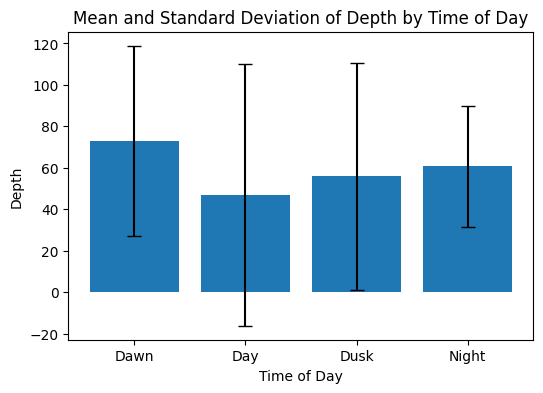

In [6]:
# Calculate mean and standard deviation of depth for each time of day
depth_stats = data.groupby('Time of Day')['Pressure'].agg(['mean', 'std']).reset_index()

# Create formatted columns for display purposes
depth_stats['Mean Depth'] = depth_stats['mean'].map('{:.2f} m'.format)
depth_stats['Standard Deviation'] = depth_stats['std'].map('{:.2f} m'.format)

# Print the table with formatted values
print("Table: Mean and Standard Deviation of Depth by Time of Day")
print(depth_stats[['Time of Day', 'Mean Depth', 'Standard Deviation']].to_string(index=False))

# Create a bar chart using the original numerical columns for mean and std
plt.figure(figsize=(6, 4))
plt.bar(depth_stats['Time of Day'], depth_stats['mean'], yerr=depth_stats['std'], capsize=5)

# Adding labels and title
plt.xlabel('Time of Day')
plt.ylabel('Depth')
plt.title('Mean and Standard Deviation of Depth by Time of Day')

# Show the plot
plt.show()

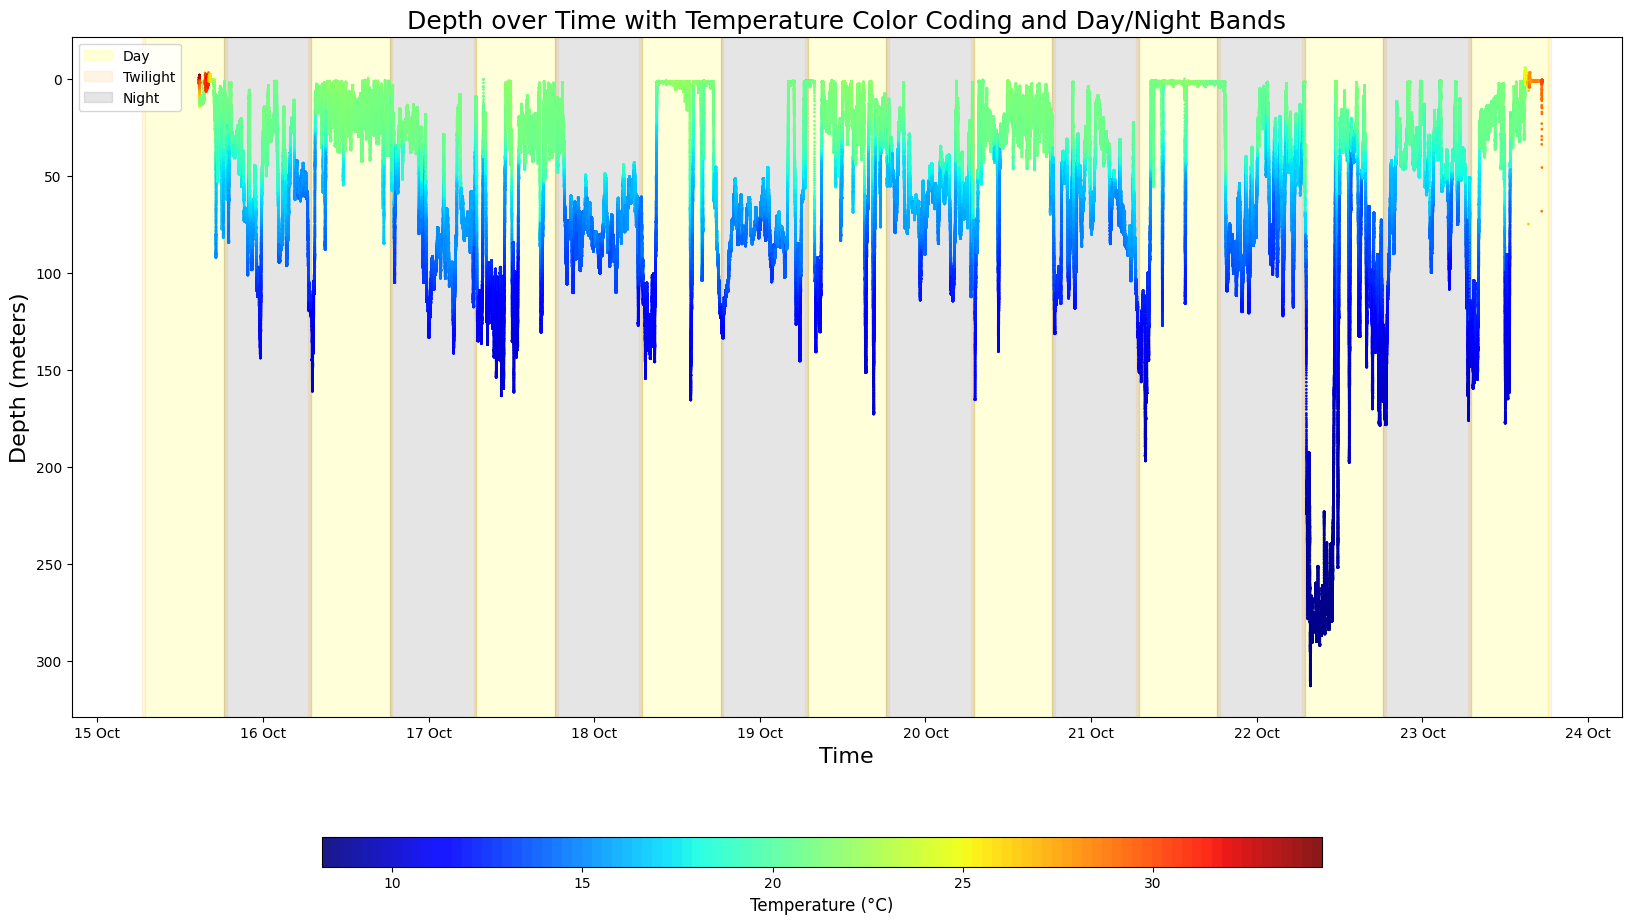

In [7]:
# Set plot titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (meters)', fontsize=16)
plt.title('Depth over Time with Temperature Color Coding and Day/Night Bands', fontsize=18)

# Plot day-night bands
plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap
cmap = plt.get_cmap('jet', 100)
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=0.9)

# Make increased depth down
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Extract handles and labels for the legend from the current axis
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend from handles and labels
plt.legend(handles, labels, loc='upper left')

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Temperature (°C)', fontsize=12)

# Show the plot
plt.show()

## Movement and Acceleration Analysis

Next, we'll analyze the shark's movement using the data from the 3-axis accelerometer. This analysis will help us understand the shark's activity levels and energy expenditure. We aim to distinguish different types of movements such as swimming speed, sudden turns, or resting periods. This will give us insights into the shark's behavior and how it interacts with its environment.


### ODBA over Time with Day/Night Bands
The graph shows sharks' Overall Dynamic Body Acceleration (ODBA) over time, marked with day (yellow) and night (black) bands.

In [8]:
def update_plot(axis_name):
    # Calculate mean and standard deviation of depth for each time of day
    stats = data.groupby('Time of Day')[axis_name].agg(['mean', 'std']).reset_index()

    # Create formatted columns for display purposes
    stats[f'Mean {axis_name}'] = stats['mean'].map('{:.2f} m'.format)
    stats['Standard Deviation'] = stats['std'].map('{:.2f} m'.format)

    # Print the table with formatted values
    print(f"Table: Mean and Standard Deviation of {axis_name} by Time of Day")
    print(stats[['Time of Day', f'Mean {axis_name}', 'Standard Deviation']].to_string(index=False))

    # Create a bar chart using the original numerical columns for mean and std
    plt.figure(figsize=(6, 4))
    plt.bar(stats['Time of Day'], stats['mean'], yerr=stats['std'], capsize=5)

    # Adding labels and title
    plt.xlabel('Time of Day')
    plt.ylabel(f'{axis_name}')
    plt.title(f'Mean and Standard Deviation of {axis_name} by Time of Day')

    # Show the plot
    plt.show()


# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA', 'Movement Variation', 'SSAA', 'Pitch', 'Roll'],
    value='ODBA',
    description='Color by:',
)

# Widget interaction
widgets.interact(update_plot, axis_name=axis_dropdown)

interactive(children=(Dropdown(description='Color by:', index=3, options=('X Axis', 'Y Axis', 'Z Axis', 'ODBA'…

<function __main__.update_plot(axis_name)>

In [9]:
# Function to update the plot based on the selected axis
def update_plot(axis_name):
  # Set plot size, titles and labels
  plt.figure(figsize=(20, 10))
  plt.xlabel('Time', fontsize=14)
  plt.ylabel(axis_name, fontsize=14)
  plt.title(f'{axis_name} Over Time with Day/Night Bands', fontsize=16)

  # Plot day-night bands
  plot_day_night_bands(sun_cycles, plt.gca())

  resampled_data = data.resample('min', on='Time Stamp').mean(numeric_only=True)

  # Calculate the moving average of ODBA with a window size
  window_size = 5
  odba_moving_average = resampled_data[axis_name].rolling(window=window_size).mean()

  # Plot the moving average ODBA line
  plt.plot(resampled_data.index, odba_moving_average, color='grey', alpha=0.5, label='Moving Average')

  cmap = plt.get_cmap('gist_rainbow', 100).reversed()
  lower_percentile = 2
  upper_percentile = 98
  lower_bound = data[axis_name].quantile(lower_percentile / 100)
  upper_bound = data[axis_name].quantile(upper_percentile / 100)
  norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

  # Scatter plot for ODBA values over time
  sc = plt.scatter(resampled_data.index, resampled_data[axis_name], s=5, alpha=0.9,
                        c=resampled_data[axis_name], cmap=cmap, norm=norm, edgecolor='none', label=axis_name)

  # Format the x-axis
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

  # Extract handles and labels for the legend from the current axis
  handles, labels = plt.gca().get_legend_handles_labels()

  # Create legend from handles and labels
  plt.legend(handles, labels, loc='upper left')

  # Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
  plt.subplots_adjust(bottom=0.20)

  # Adjust the position of the colorbar
  colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

  # Create the colorbar with the specified axes and orientation
  cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

  # Set the label for the colorbar
  cbar.set_label(axis_name, fontsize=14)

  # Show the plot
  plt.show()


# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA', 'Movement Variation', 'SSAA', 'Pitch', 'Roll'],
    value='ODBA',
    description='Color by:',
)

# Widget interaction
widgets.interact(update_plot, axis_name=axis_dropdown)

interactive(children=(Dropdown(description='Color by:', index=3, options=('X Axis', 'Y Axis', 'Z Axis', 'ODBA'…

<function __main__.update_plot(axis_name)>

### Depth over Time with ODBA Color Coding

### Axis Values Over Time with ODBA Color Coding

In [10]:
# Function to update the plot based on the selected axis
def update_plot(axis_names):
    # Create a subplot layout
    fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

    # Store the day/night patches for the legend
    day_patch = None
    twilight_patch = None
    night_patch = None

    cmap = plt.get_cmap('gist_rainbow_r', 100)
    lower_percentile = 2
    upper_percentile = 98

    resampled_data = data.resample('min', on='Time Stamp').mean(numeric_only=True)

    lower_bound = resampled_data['ODBA'].quantile(lower_percentile / 100)
    upper_bound = resampled_data['ODBA'].quantile(upper_percentile / 100)
    norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

    for i, axis in enumerate(axis_names):
        # Call plot_day_night_bands for each subplot
        plot_day_night_bands(sun_cycles, axs[i])

        # Scatter plot for color-coded ODBA data
        sc = axs[i].scatter(data['Time Stamp'], data[axis], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)
        axs[i].set_ylabel(f'{axis} (g)')

        window_size = 600
        # Calculate the moving average of the current axis
        moving_average = resampled_data[axis].rolling(window=window_size).mean()
        # Plot the moving average line
        axs[i].plot(resampled_data.index, moving_average, color='black', alpha=1, label='Average')

        # Format the x-axis
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # After plotting on all subplots, extract handles and labels for the legend from the last axis
    handles, labels = axs[-1].get_legend_handles_labels()

    # Create legend from handles and labels and add it to the first subplot
    axs[0].legend(handles, labels, loc='upper left')

    # Set common X-Axis properties
    axs[-1].set_xlabel('Time')

    # Set the title for the entire figure
    fig.suptitle('Axis Values Over Time with ODBA Color Coding and Day/Night Bands', fontsize=16)

    # Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
    plt.subplots_adjust(bottom=0.20)

    # Adjust the position of the colorbar
    # These values are fractions of the figure size. (left, bottom, width, height)
    colorbar_axes = fig.add_axes([0.25, 0.05, 0.5, 0.03])

    # Create the colorbar with the specified axes and orientation
    cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
    cbar.set_label('ODBA (g)', fontsize=12)

    # Adjust layout
    fig.subplots_adjust(bottom=0.15, top=0.85)

    # Show the plot
    plt.show()


# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=[['X Dynamic', 'Y Dynamic', 'Z Dynamic'], ['X Axis', 'Y Axis', 'Z Axis']],
    value=['X Dynamic', 'Y Dynamic', 'Z Dynamic'],
    description='Axis',
)

# Widget interaction
widgets.interact(update_plot, axis_names=axis_dropdown)

interactive(children=(Dropdown(description='Axis', options=(['X Dynamic', 'Y Dynamic', 'Z Dynamic'], ['X Axis'…

<function __main__.update_plot(axis_names)>

### Depth over Time with Axis Value or Summary Statistics Color Coding
Select the X, Y, or Z axis or a summary Statistic for color-coding via a dropdown menu.
Automatically update the plot based on the axis chosen.

In [11]:
# Function to update the plot based on the selected axis
def update_plot(axis_name):
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_day_night_bands(sun_cycles, ax)

    # Dynamically adjusting the color range based on selected axis
    lower_bound = data[axis_name].quantile(0.02)
    upper_bound = data[axis_name].quantile(0.98)
    norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

    # Scatter plot
    sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data[axis_name],
                     cmap='jet', norm=norm, s=1, alpha=1.0)

    # Enhancing the plot
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # Plot titles and labels
    plt.title(f'Depth over Time with {axis_name} Color Coding and Day/Night Bands', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Depth (meters)', fontsize=12)

    # Extract handles and labels for the legend from the current axis
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create legend from handles and labels
    plt.legend(handles, labels, loc='upper left')

    # Adding colorbar
    colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])
    cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
    cbar.set_label(f'{axis_name}', fontsize=12)

    plt.show()

# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['X Dynamic', 'Y Dynamic', 'Z Dynamic', 'X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA', 'Movement Variation', 'SSAA', 'Pitch', 'Roll'],
    value='X Dynamic',
    description='Color by:',
)

# Widget interaction
widgets.interact(update_plot, axis_name=axis_dropdown)

interactive(children=(Dropdown(description='Color by:', options=('X Dynamic', 'Y Dynamic', 'Z Dynamic', 'X Axi…

<function __main__.update_plot(axis_name)>

## Unsupervised Learning Analysis of Accelerometer Data
In this section, we will apply unsupervised learning techniques to classify segments of the accelerometer data (x, y, z axes). Our goal is to identify distinct patterns in the data that may correspond to different shark behaviors. We will use clustering algorithms to group similar data points and then analyze these clusters to infer possible behaviors.


In [12]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

# Configuration Parameters
WINDOW_SIZE = 50  # Window size for rolling calculations
OVERLAP = 25      # Overlap between windows
FEATURES = ['ODBA', 'X Dynamic', 'Y Dynamic', 'Z Dynamic']  # List of features to include
ROLLING_WINDOW = '0.1H'  # Rolling window for mean calculation

# Function to Create Feature Windows
def calculate_rolling_features(df, features, rolling_window):
    for feature in features:
        rolling_mean = df[feature].rolling(rolling_window, min_periods=1).mean()
        deviation_col = f'{feature}_deviation'
        df[f'rolling_mean_{feature}'] = rolling_mean
        df[deviation_col] = df[feature] - rolling_mean
        df[deviation_col].dropna(inplace=True)  # Drop NaN values only in the deviation columns
    return df

# Function to Create Feature Windows and Extract Statistical Features
def create_feature_windows(df, window_size, overlap, features):
    windows = []
    for start in range(0, len(df) - window_size, window_size - overlap):
        end = start + window_size
        window = df.iloc[start:end]
        window_features = {}
        # Calculate statistical features for each specified feature
        for feature in features:
            deviation_col = f'{feature}_deviation'
            window_features[f'{feature}_mean_dev'] = window[deviation_col].mean()
            window_features[f'{feature}_std_dev'] = window[deviation_col].std()
        windows.append(window_features)
    return pd.DataFrame(windows)

# Main analysis code
def main_analysis(data):
    data_processed = data.copy()

    # Check and handle NaN values in original data
    if data_processed.isnull().values.any():
        print("NaN values found in data. Handling NaNs...")
        # Handle NaNs here (e.g., fillna, interpolate, etc.)
        data_processed.fillna(method='ffill', inplace=True)  # Example: forward fill

    data_processed.set_index('Time Stamp', inplace=True)

    # Calculate rolling means and deviations
    data_processed = calculate_rolling_features(data_processed, FEATURES, ROLLING_WINDOW)
    print("Size after rolling calculations:", data_processed.shape)

    if data_processed.empty:
        raise ValueError("No data after rolling calculations. Check your data and ROLLING_WINDOW parameter.")

    # Create windows and extract features
    windowed_data = create_feature_windows(data_processed, WINDOW_SIZE, OVERLAP, FEATURES)
    print("Size of windowed_data:", windowed_data.shape)

    if windowed_data.empty:
        raise ValueError("No data in windowed_data. Check WINDOW_SIZE and OVERLAP parameters.")

    # Impute missing values in windowed_data
    imputer = SimpleImputer(strategy='mean')
    windowed_data_imputed = imputer.fit_transform(windowed_data)

    # Normalize the feature data
    scaler = StandardScaler()
    windowed_data_scaled = scaler.fit_transform(windowed_data_imputed)

    # Apply K-Means clustering
    n_clusters = 6  # Set the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    clusters = kmeans.fit_predict(windowed_data_scaled)

    # Add cluster assignments back to the original data
    data_processed['cluster'] = None
    for i, start in enumerate(range(0, len(data_processed) - WINDOW_SIZE, WINDOW_SIZE - OVERLAP)):
        end = start + WINDOW_SIZE
        data_processed.iloc[start:end, data_processed.columns.get_loc('cluster')] = clusters[i]

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(windowed_data_scaled, clusters)
    print(f"Silhouette Score: {silhouette_avg:.2f}")

    return data_processed

data_processed = main_analysis(data)

NaN values found in data. Handling NaNs...
Size after rolling calculations: (700619, 26)
Size of windowed_data: (28023, 8)
Silhouette Score: 0.23


<ipython-input-13-e88e4a9480bf>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', n_clusters)  # Access colormap with updated method


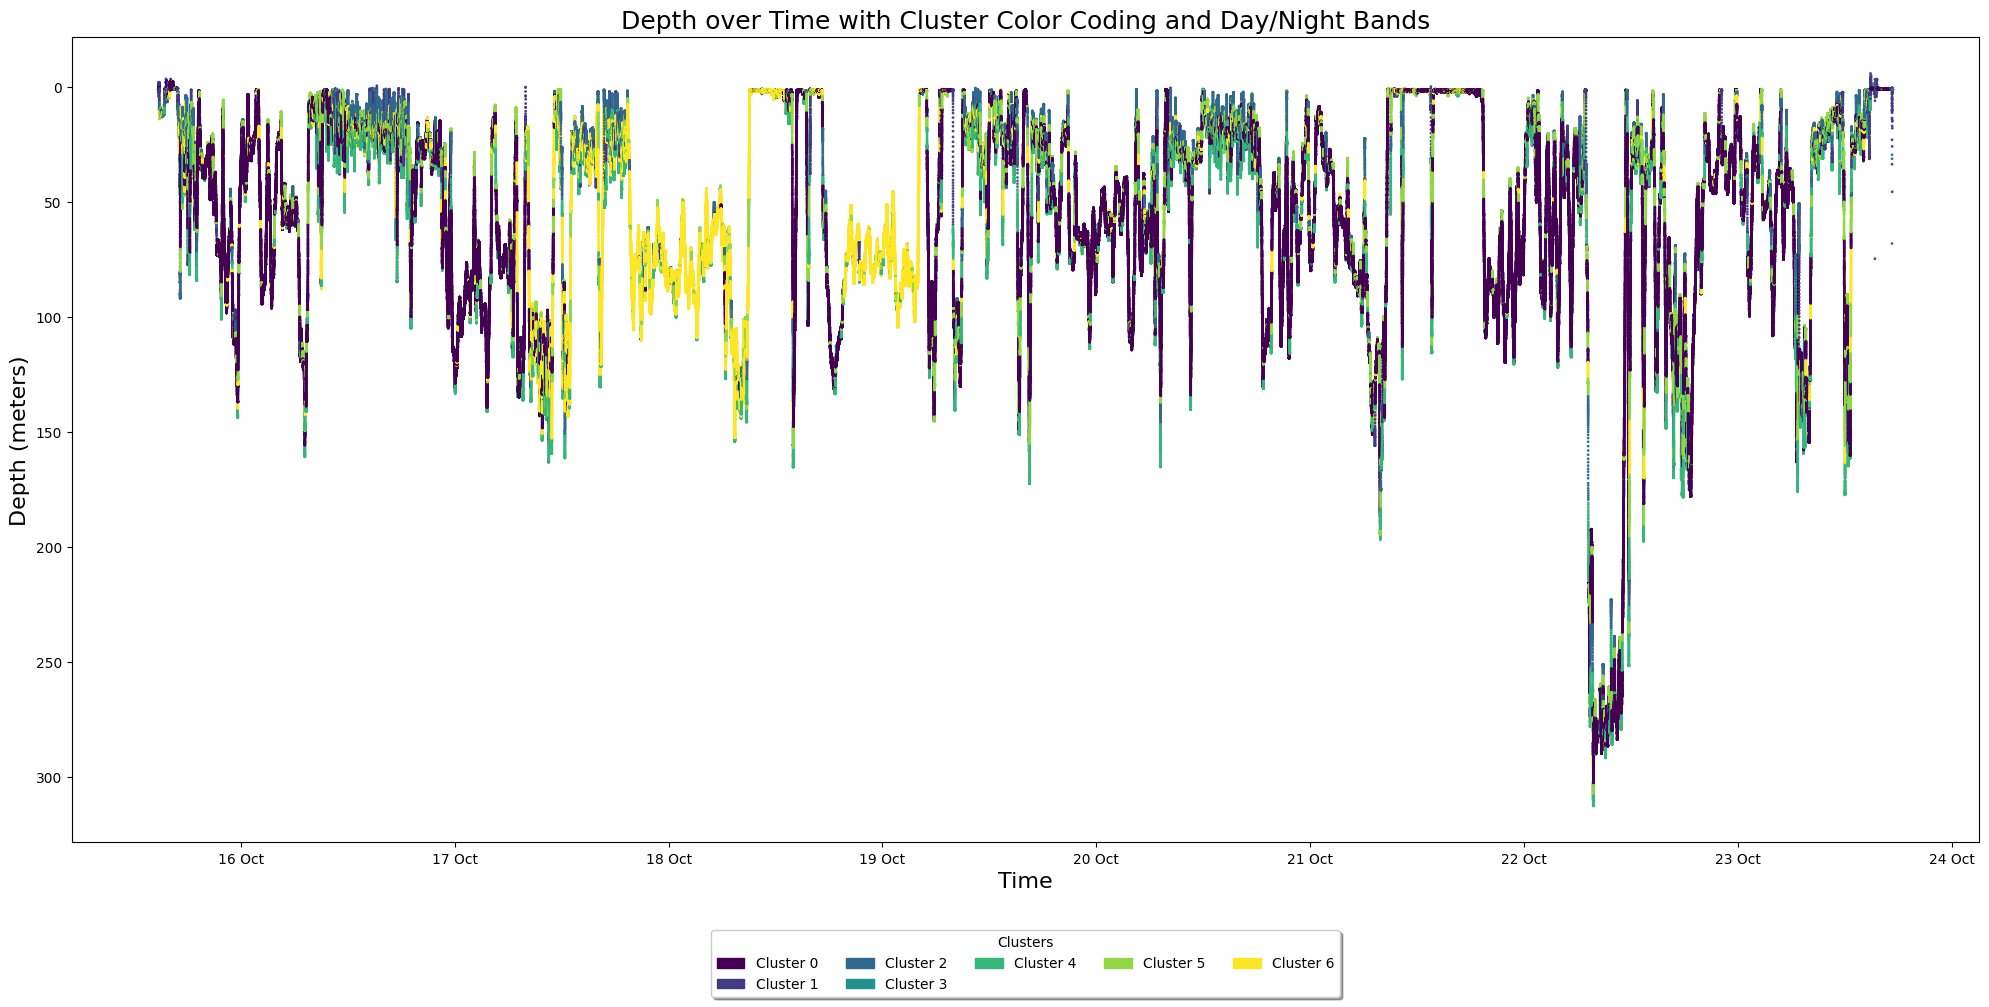

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.cm as cm  # Import colormap module

# Assuming 'n_clusters' is the number of clusters you determined with KMeans
n_clusters = len(data_processed['cluster'].unique())

# Set plot titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (meters)', fontsize=16)
plt.title('Depth over Time with Cluster Color Coding and Day/Night Bands', fontsize=18)

# Plot day-night bands
# Ensure 'sun_cycles' is defined and formatted correctly
# plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap for clusters
cmap = cm.get_cmap('viridis', n_clusters)  # Access colormap with updated method

# Create a list of patches for the legend
cluster_patches = [mpatches.Patch(color=cmap(i/n_clusters), label=f'Cluster {i}') for i in range(n_clusters)]

# Plot depth data against time, colored by cluster
sc = plt.scatter(data_processed.index, data_processed['Pressure'], c=data_processed['cluster'], cmap=cmap, s=1, alpha=0.9)

# Make increased depth down
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Position the legend under the graph
plt.legend(handles=cluster_patches, title='Clusters', loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

# Increase the bottom margin to ensure the legend does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.25)

# Show the plot
plt.tight_layout()
plt.show()


No peaks detected in X Dynamic.
No peaks detected in Y Dynamic.
No peaks detected in Z Dynamic.


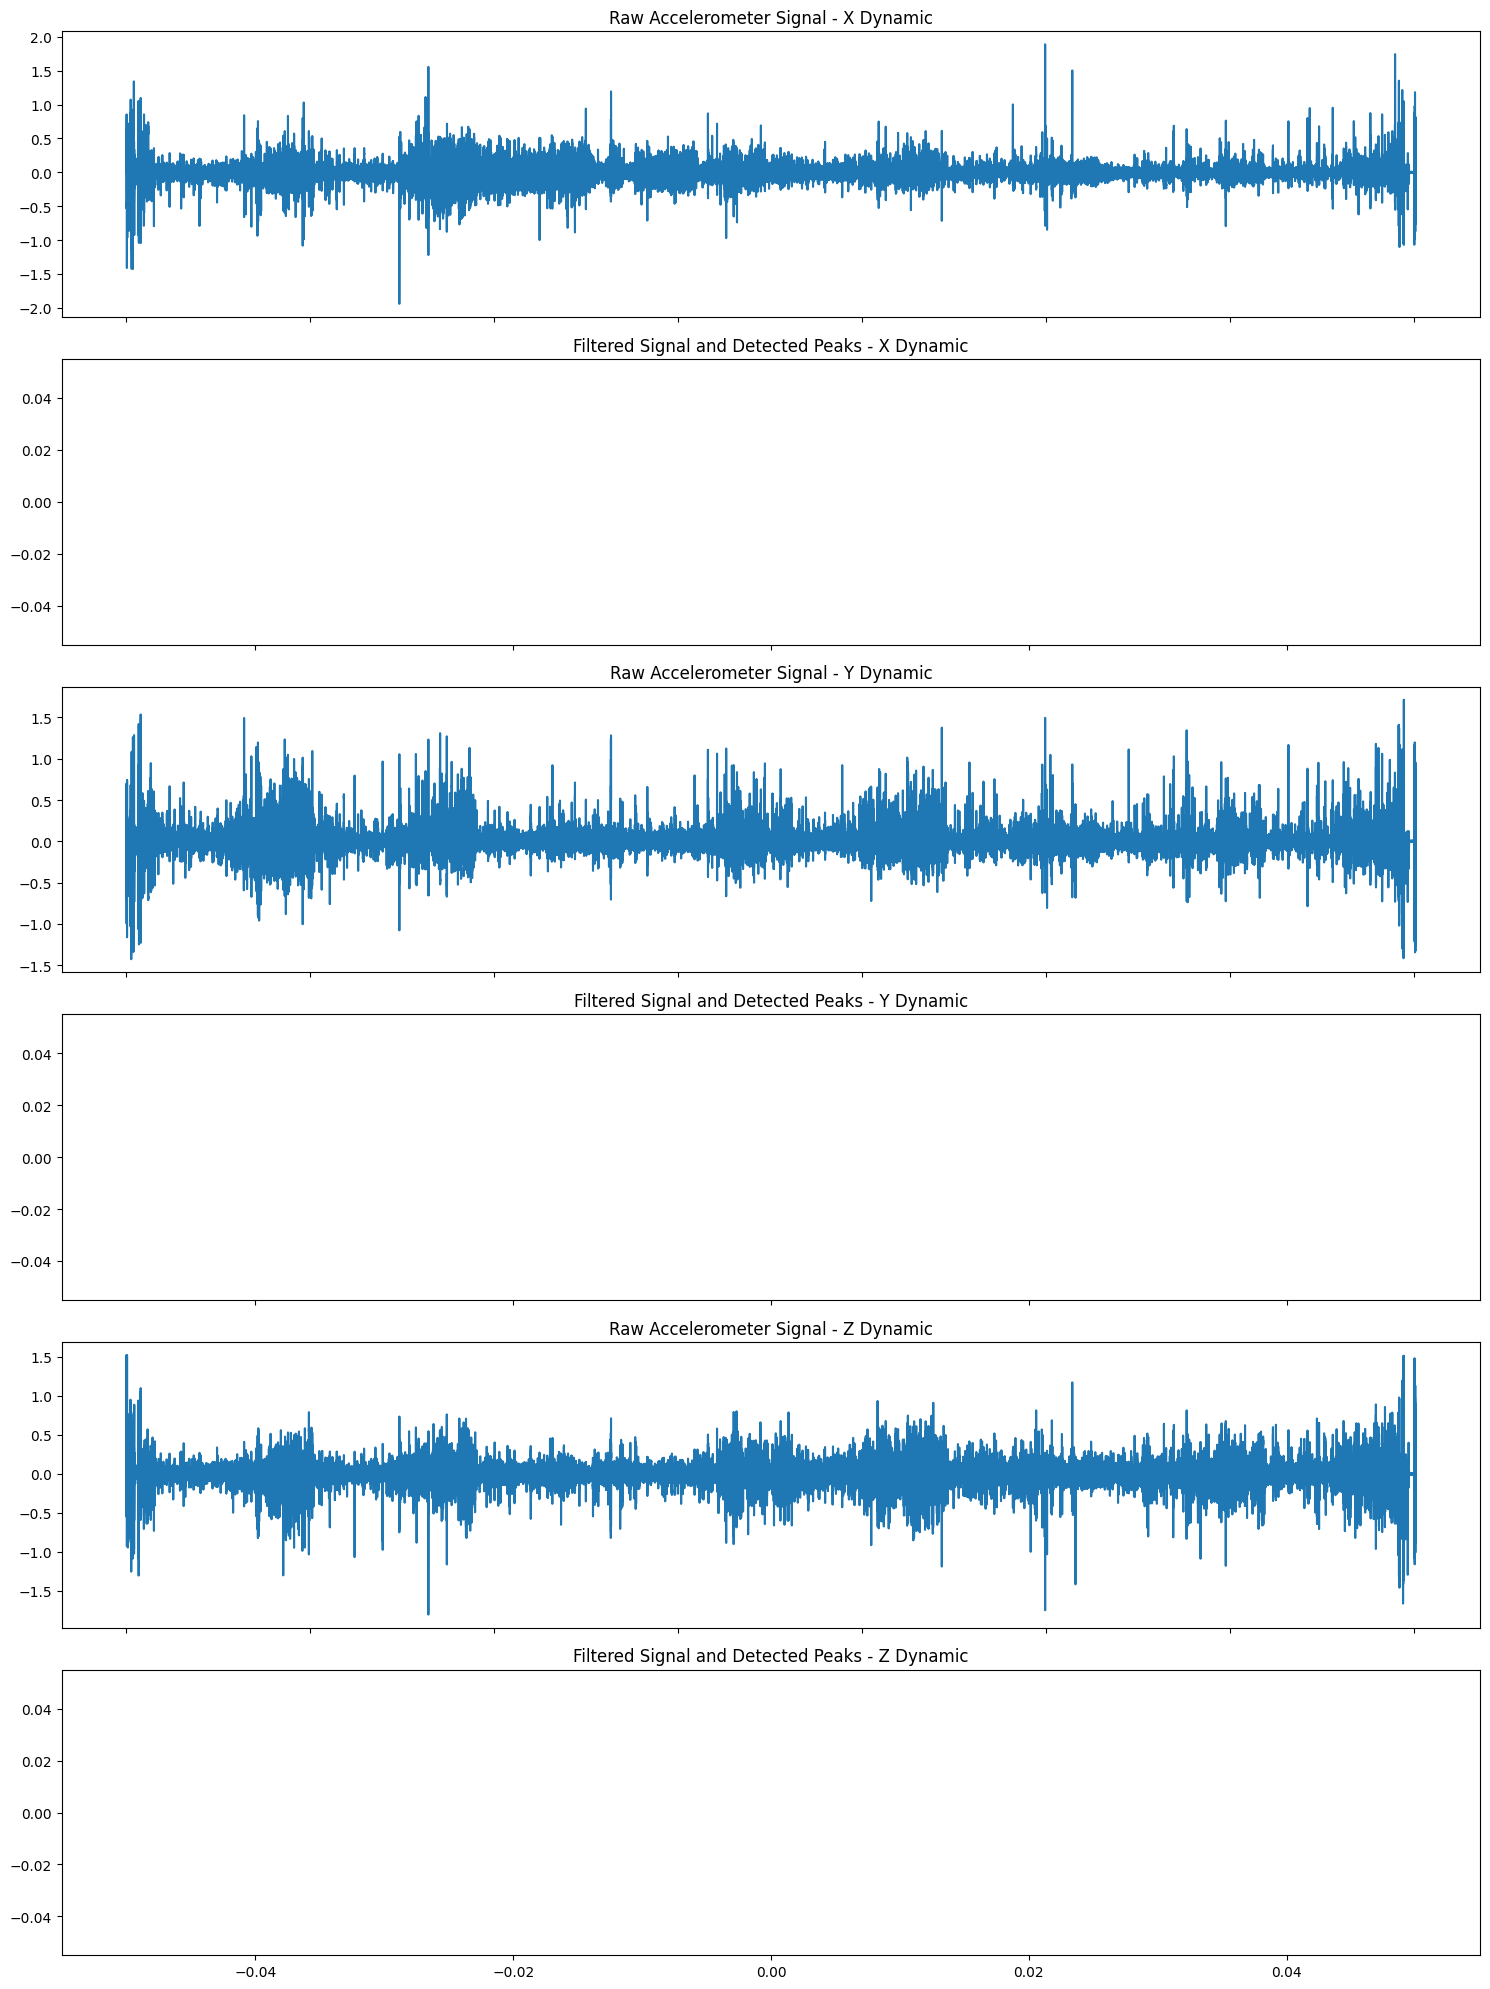

In [14]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

# Function to design a high-pass Butterworth filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Function to apply the high-pass filter to the data
def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to calculate tail beat frequency with more stringent peak detection criteria
def calculate_tail_beat_frequency(df, axis, sampling_rate=50, cutoff_frequency=0.01, min_peak_distance=0.5):
    # Increased prominence and width to detect more significant peaks
    filtered_signal = highpass_filter(df[axis], cutoff_frequency, sampling_rate)
    # Start with lenient parameters and then tighten
    #peaks, properties = find_peaks(filtered_signal, prominence=0.01) # Adjust this value as needed
    # Uncomment and adjust the following lines one at a time to fine-tune peak detection
    #peaks, properties = find_peaks(filtered_signal, prominence=0.01, distance=sampling_rate/2)
    #peaks, properties = find_peaks(filtered_signal, prominence=0.01, width=1)
    peaks, properties = find_peaks(filtered_signal, prominence=0.01, distance=sampling_rate/2, width=1)


    frequencies = []
    peak_times = []

    if len(peaks) > 1:
        peak_times = peaks / sampling_rate
        time_diffs = np.diff(peak_times)
        frequencies = 1 / time_diffs

    avg_frequency = np.nan if len(frequencies) == 0 else np.mean(frequencies)
    return avg_frequency, frequencies, peak_times, filtered_signal, peaks, properties

# Assuming 'data' is a DataFrame with accelerometer signals
# Axes to analyze
axes = ['X Dynamic', 'Y Dynamic', 'Z Dynamic']

# Set up subplot for raw and filtered signals
fig, axs = plt.subplots(len(axes) * 2, 1, figsize=(15, 20))  # 3 axes times 2 for raw and filtered signals

for i, axis in enumerate(axes):
    # Calculate tail beat frequency and get debug information
    avg_freq, freqs, peak_times, filtered_signal, peaks, properties = calculate_tail_beat_frequency(data, axis, sampling_rate=50, cutoff_frequency=0.01, min_peak_distance=0.5)

    # Plotting raw signal
    axs[2*i].plot(data[axis], label=f'Raw Accelerometer Signal - {axis}')
    axs[2*i].set_title(f'Raw Accelerometer Signal - {axis}')
    axs[2*i].label_outer()

    # Plotting filtered signal and detected peaks
    axs[2*i + 1].plot(filtered_signal, label=f'Filtered Signal - {axis}')
    axs[2*i + 1].plot(peaks, filtered_signal[peaks], "x", label=f'Detected Peaks - {axis}')
    axs[2*i + 1].set_title(f'Filtered Signal and Detected Peaks - {axis}')
    axs[2*i + 1].label_outer()

    # Debug information
    if len(peaks) == 0:
        print(f"No peaks detected in {axis}.")
    else:
        print(f"Detected {len(peaks)} peaks in {axis}. Avg Tail Beat Frequency: {avg_freq} Hz")
        print(f"Properties of detected peaks: {properties}")

plt.tight_layout()
plt.show()


### References
- **Kadar, J.P., Ladds, M.A., Day, J., Lyall, B., & Brown, C. (2020). Assessment of Machine Learning Models to Identify Port Jackson Shark Behaviours Using Tri-Axial Accelerometers. Sensors, 20(24), 7096.** This study details the methodology used to quantify and differentiate various behaviors in Port Jackson sharks using tri-axial accelerometers. The techniques and findings from this paper provide the foundational approach for the summary statistics used in this analysis.